# Parse Binance Market DataLoad downloaded market data from a given directory into a usable dataframe.

#### Fetch Latest Market Data

In [1]:
!docker-compose -f ./fa.plutus/docker-compose.yml run --rm freqtrade download-data --exchange binance --days 3000 -t 1h

2021-10-19 17:31:15,114 - freqtrade.configuration.configuration - INFO - Using config: user_data/config.json ...
2021-10-19 17:31:15,121 - freqtrade.loggers - INFO - Verbosity set to 0
2021-10-19 17:31:15,121 - freqtrade.configuration.configuration - INFO - Using exchange binance
2021-10-19 17:31:15,186 - freqtrade.configuration.configuration - INFO - Using user-data directory: /freqtrade/user_data ...
2021-10-19 17:31:15,187 - freqtrade.configuration.configuration - INFO - Using data directory: /freqtrade/user_data/data/binance ...
2021-10-19 17:31:15,188 - freqtrade.configuration.configuration - INFO - timeframes --timeframes: ['1h']
2021-10-19 17:31:15,188 - freqtrade.configuration.configuration - INFO - Detected --days: 3000
2021-10-19 17:31:15,188 - freqtrade.configuration.check_exchange - INFO - Checking exchange...
2021-10-19 17:31:15,197 - freqtrade.configuration.check_exchange - INFO - Exchange "binance" is officially supported by the Freqtrade development team.
2021-10-19 17:

#### Install & Import Dependencies

In [2]:
import sys

!conda install --yes --prefix {sys.prefix} ta-lib

Solving environment: ...working... done

# All requested packages already installed.



In [3]:
import sys

!{sys.executable} -m pip install -U TA-Lib

  Using cached TA-Lib-0.4.21.tar.gz (270 kB)


  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\miniforge3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\deanm\\AppData\\Local\\Temp\\pip-install-vou7xjoa\\ta-lib_936e396b6a1040b7b163dffbacd1631c\\setup.py'"'"'; __file__='"'"'C:\\Users\\deanm\\AppData\\Local\\Temp\\pip-install-vou7xjoa\\ta-lib_936e396b6a1040b7b163dffbacd1631c\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\deanm\AppData\Local\Temp\pip-wheel-uwc8zxj8'
       cwd: C:\Users\deanm\AppData\Local\Temp\pip-install-vou7xjoa\ta-lib_936e396b6a1040b7b163dffbacd1631c\
  Complete output (26 lines):
  C:\Users\deanm\AppData\Local\Temp\pip-install-vou7xjoa\ta-lib_936e396b6a1040b7b163dffbacd1631c\setup.py:76: UserWa

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for TA-Lib
Failed to build TA-Lib
  Attempting uninstall: TA-Lib
    Found existing installation: ta-lib 0.4.19
    Uninstalling ta-lib-0.4.19:
      Successfully uninstalled ta-lib-0.4.19
    Running setup.py install for TA-Lib: started
    Running setup.py install for TA-Lib: finished with status 'error'
  Rolling back uninstall of ta-lib
  Moving to c:\programdata\miniforge3\lib\site-packages\ta_lib-0.4.19.dist-info\
   from C:\ProgramData\miniforge3\Lib\site-packages\~a_lib-0.4.19.dist-info
  Moving to c:\programdata\miniforge3\lib\site-packages\talib\
   from C:\ProgramData\miniforge3\Lib\site-packages\~alib


In [2]:

from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import talib
from talib import RSI, BBANDS
import pickle

#### Functions to Assist with Data Parsing

In [3]:
def get_pair_name(path):
    pair_name = (path
                    .split('/')[-1]
                    .split('.json')[0]
                    .split('-')[0])
    
    return pair_name

def load_path_data(path):
    df = pd.read_json(path)
    df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    
    return df

#### Load & Parse Files

In [4]:
data_relative_path = './fa.plutus/user_data/data/binance'
market_file_names = [ f for f in listdir(data_relative_path) if (isfile(join(data_relative_path, f)) and '.json' in f) ]
market_file_paths = np.array([f'{data_relative_path}/{f}' for f in market_file_names ])
market_data = { get_pair_name(path):load_path_data(path) for path in market_file_paths }

#### Featurize Data
For the features of the data we will add
- The top 5 indicator values.
- The hour of day.
- The day of week.
- The week of the year.
- The month of year.

In [5]:
def featurize_market_data(market_data):
    # Perform the transformation for each pair.
    for pair in market_data:
        # Featurizing pair "{pair}" with seasonality.
        pair_df = market_data[pair]
        pair_df['hour'] = pair_df.apply(lambda x: x['time'].hour, axis=1)
        pair_df['day'] = pair_df.apply(lambda x: x['time'].day, axis=1)
        pair_df['week'] = pair_df.apply(lambda x: x['time'].week, axis=1)
        pair_df['month'] = pair_df.apply(lambda x: x['time'].month, axis=1)
        
        # Featurizing pair "{pair}" with indicators.
        pair_df['sma'] = talib.SMA(pair_df['close'])
        time_periods = [ 14, 20]
        stds = [ 2, 3, 4 ]
        
        for period in time_periods:
            pair_df[f'rsi_tp{period}'] = RSI(pair_df['close'], timeperiod=period)
            pair_df['adx'] = talib.ADX(pair_df['high'], pair_df['low'], pair_df['close'], timeperiod=period)
            slowk, slowd = talib.STOCH(pair_df['high'], pair_df['low'], pair_df['close'], fastk_period=period)
            pair_df[f'stoch_slow_k_tp_{period}'] = slowk
            pair_df[f'stoch_slow_d_tp_{period}'] = slowd
            
            for deviation in stds:
                upper, middle, lower = BBANDS(pair_df['close'], timeperiod=period, nbdevup=deviation, nbdevdn=deviation, matype=0)
                pair_df[f'bb_upper_tp{period}_sd{deviation}'] = upper
                pair_df[f'bb_middle_tp{period}_sd{deviation}'] = middle
                pair_df[f'bb_lower_tp{period}_sd{deviation}'] = lower
        
    return market_data

#### Persist & Load Featurized Market Data

In [6]:
featurized_market_data = featurize_market_data(market_data)

In [7]:
model_file_path = './data/featurized_market_data.p'

with open(model_file_path, 'wb') as fp:
    pickle.dump(featurized_market_data, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
model_file_path = './data/featurized_market_data.p'

with open(model_file_path, 'rb') as fp:
    featurized_market_data = pickle.load(fp)

#### Sample Data

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

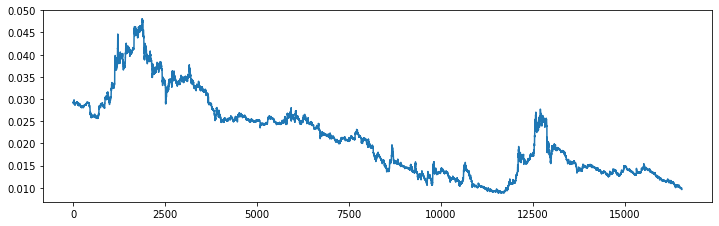

In [10]:
bch_data = featurized_market_data['BCH_BTC']

# We create our figure and specify the size:
fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot(3, 1, 1)

# We can now plot the data on each of the subplots:
ax1.plot(featurized_market_data['BCH_BTC']['close'], label = 'Random Data')